Rethinking the G430L and the potential for a chromosphere contiuumn detection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel, convolve_fft, Gaussian1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/media/david/2tb_ext_hd/hddata/mega_muscles/data/g430l/'
root = 'odlm41010'

In [3]:
data = fits.getdata('{}{}_sx1.fits'.format(path, root), 1)[0]
w, f, e, dq = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ']


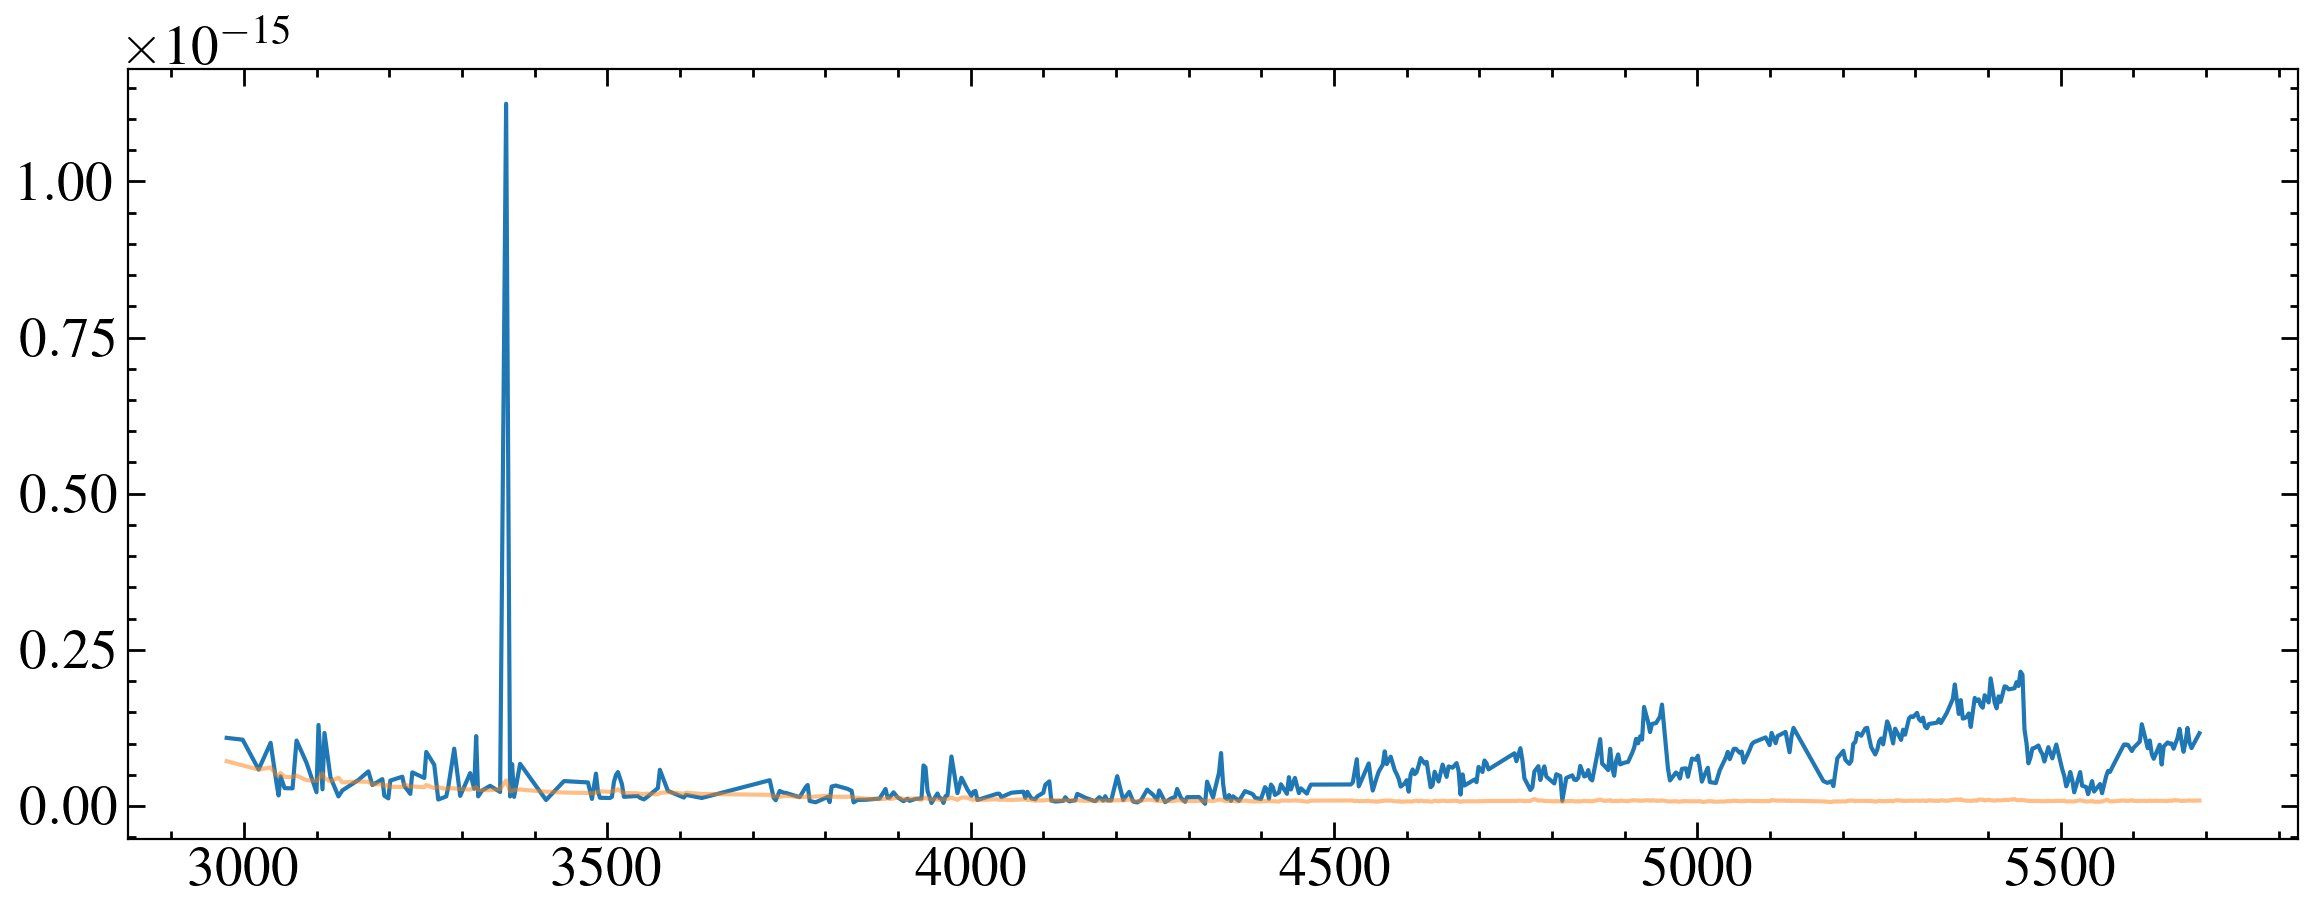

In [4]:
fig, ax = plt.subplots()
ax.plot(w[dq ==0], f[dq ==0])
ax.plot(w[dq ==0], e[dq ==0], alpha=0.5)

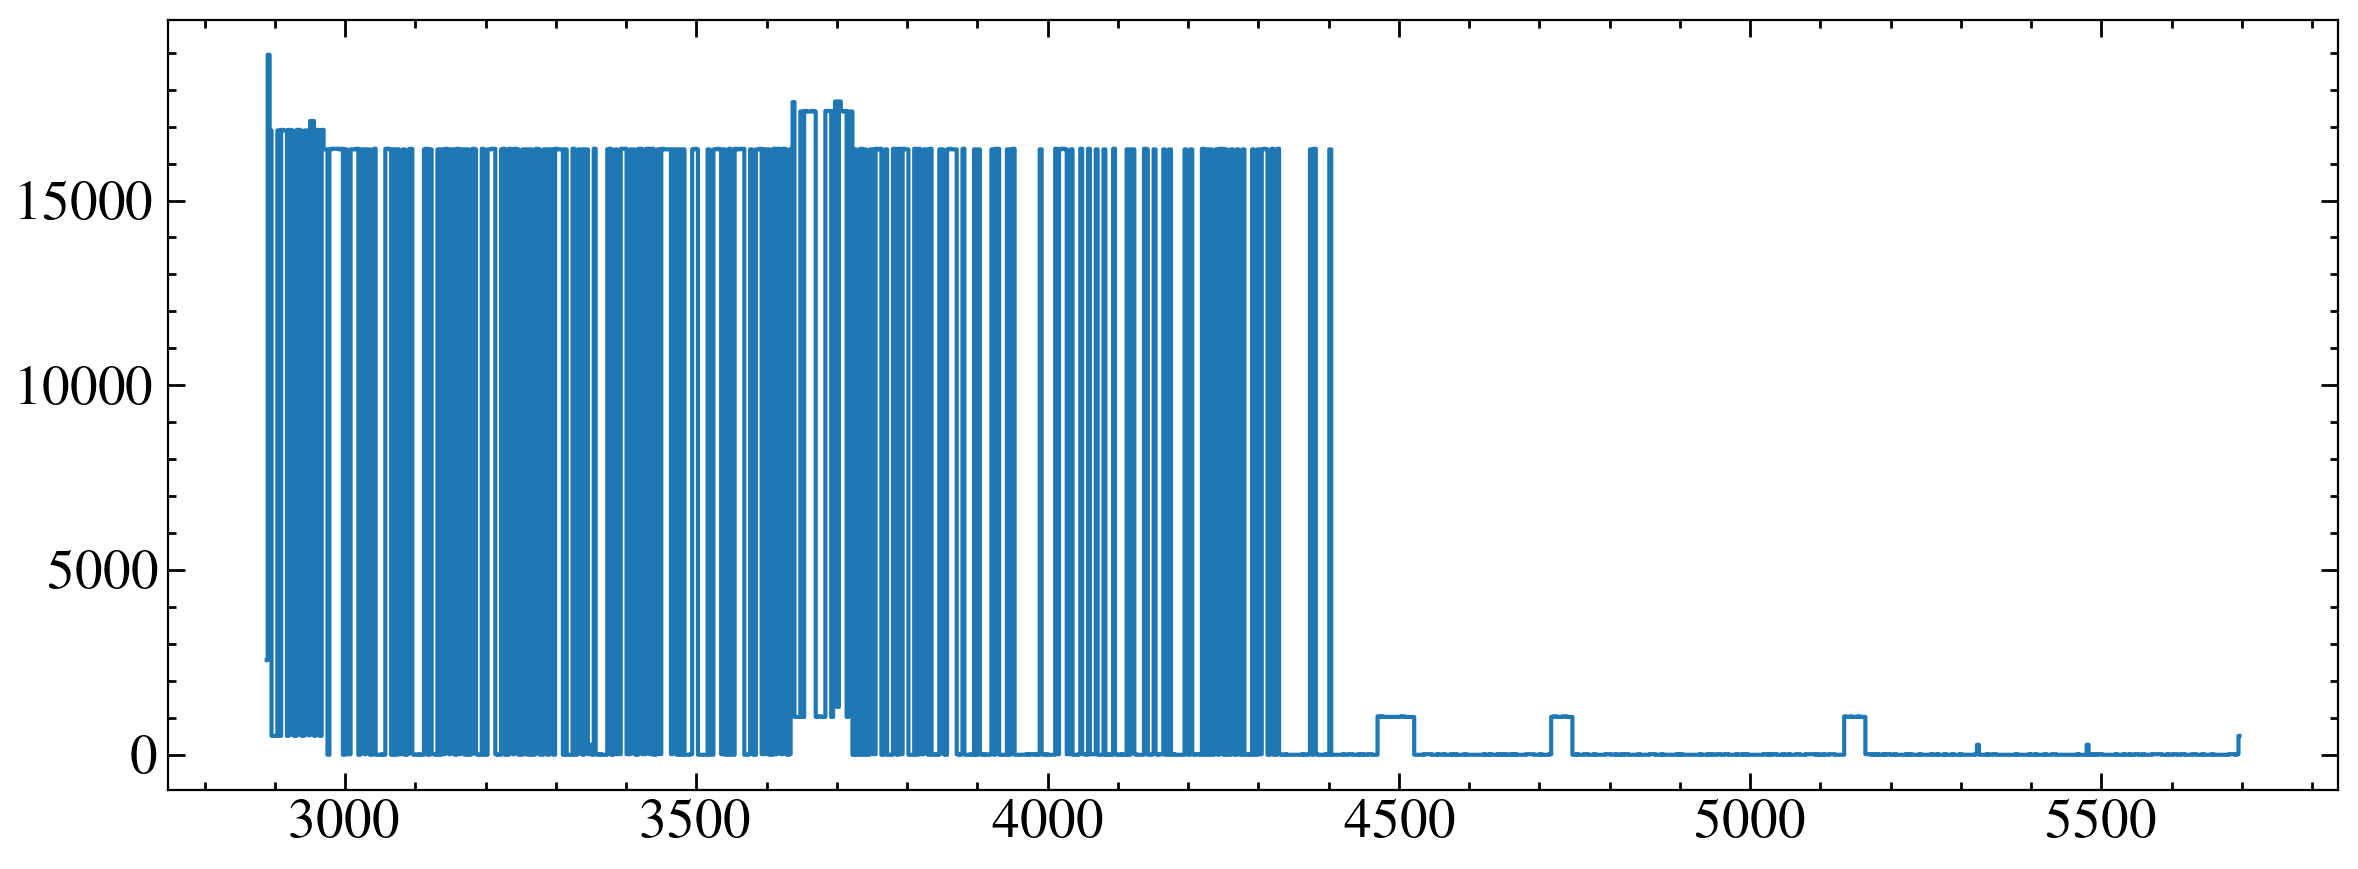

In [5]:
fig, ax = plt.subplots()
ax.step(w, dq, where='mid')
# ax.set_yscale('log')

DQ = 16384 Extracted flux not CTI corrected because gross counts are < 0. Ignoe DQ when rebinning then.

896 2.7463262994415345


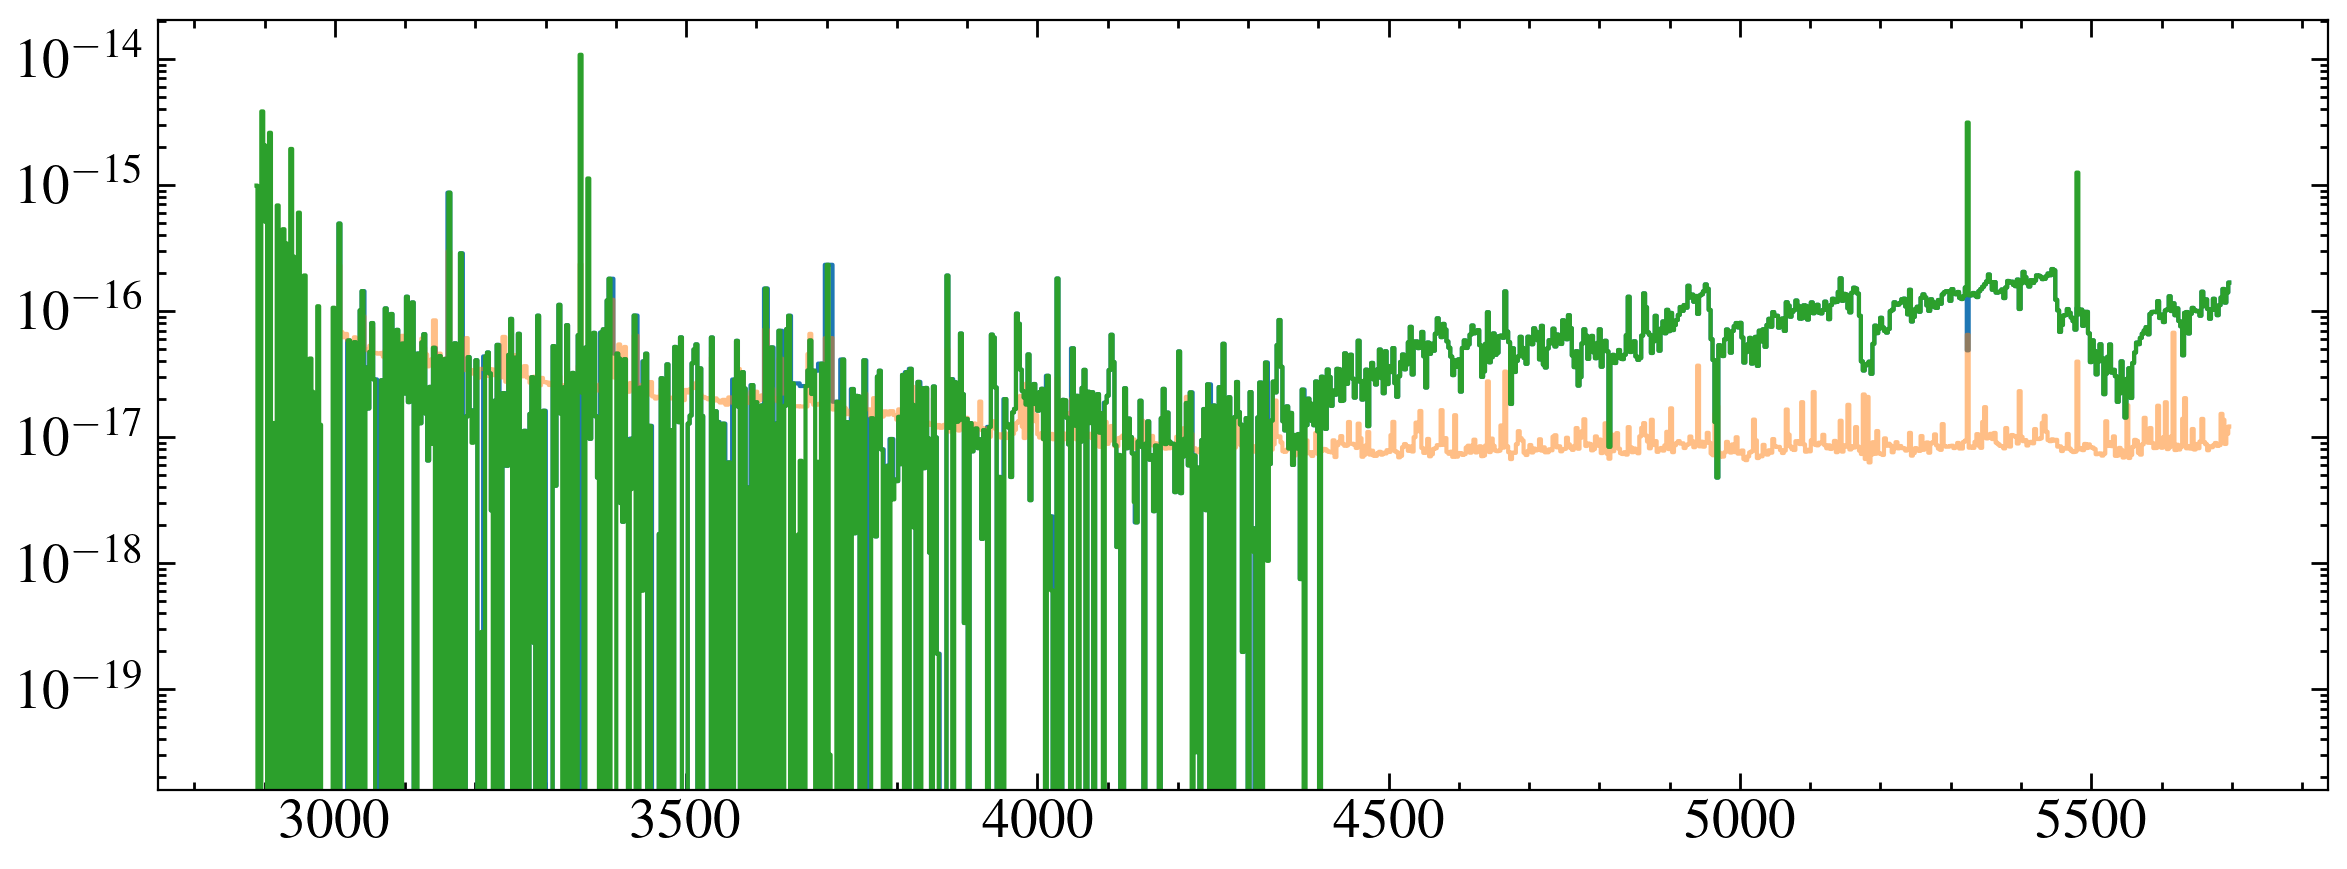

In [6]:
dq1 = dq - 16384  


mask = (w >3000) & (dq1 <1)
w1, f1, e1 = w[mask], f[mask], e[mask]
for i in range(len(f1)):
    if f1[i] > 1e-15:
        f1[i] = np.median([f[i-1], f[i+1]])
        


fig, ax = plt.subplots()
ax.step(w1, f1, where='mid')
ax.step(w1, e1, alpha=0.5, where='mid')

ax.set_yscale('log')

print(len(w1), np.median(np.diff(w1)))


hlsppath = '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/TRAPPIST-1/hlsp_muscles_hst_stis_trappist-1_g430l_v24_component-spec.fits'
data2 = fits.getdata(hlsppath, 1)
ax.step(data2['WAVELENGTH'], data2['FLUX'], where='mid')

#why is the flux in the HLSP bigger???

In [7]:
from specutils import Spectrum1D
from specutils.manipulation import FluxConservingResampler
from astropy.nddata import StdDevUncertainty


14
36


/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/specutils/manipulation/resample.py:217: RuntimeWarning: divide by zero encountered in reciprocal
  output_errs = InverseVariance(np.reciprocal(output_errs))
/tmp/ipykernel_108104/1067016869.py:18: RuntimeWarning: invalid value encountered in divide
  ax[1].scatter(w2, f2/e2, s=5, c='C0')


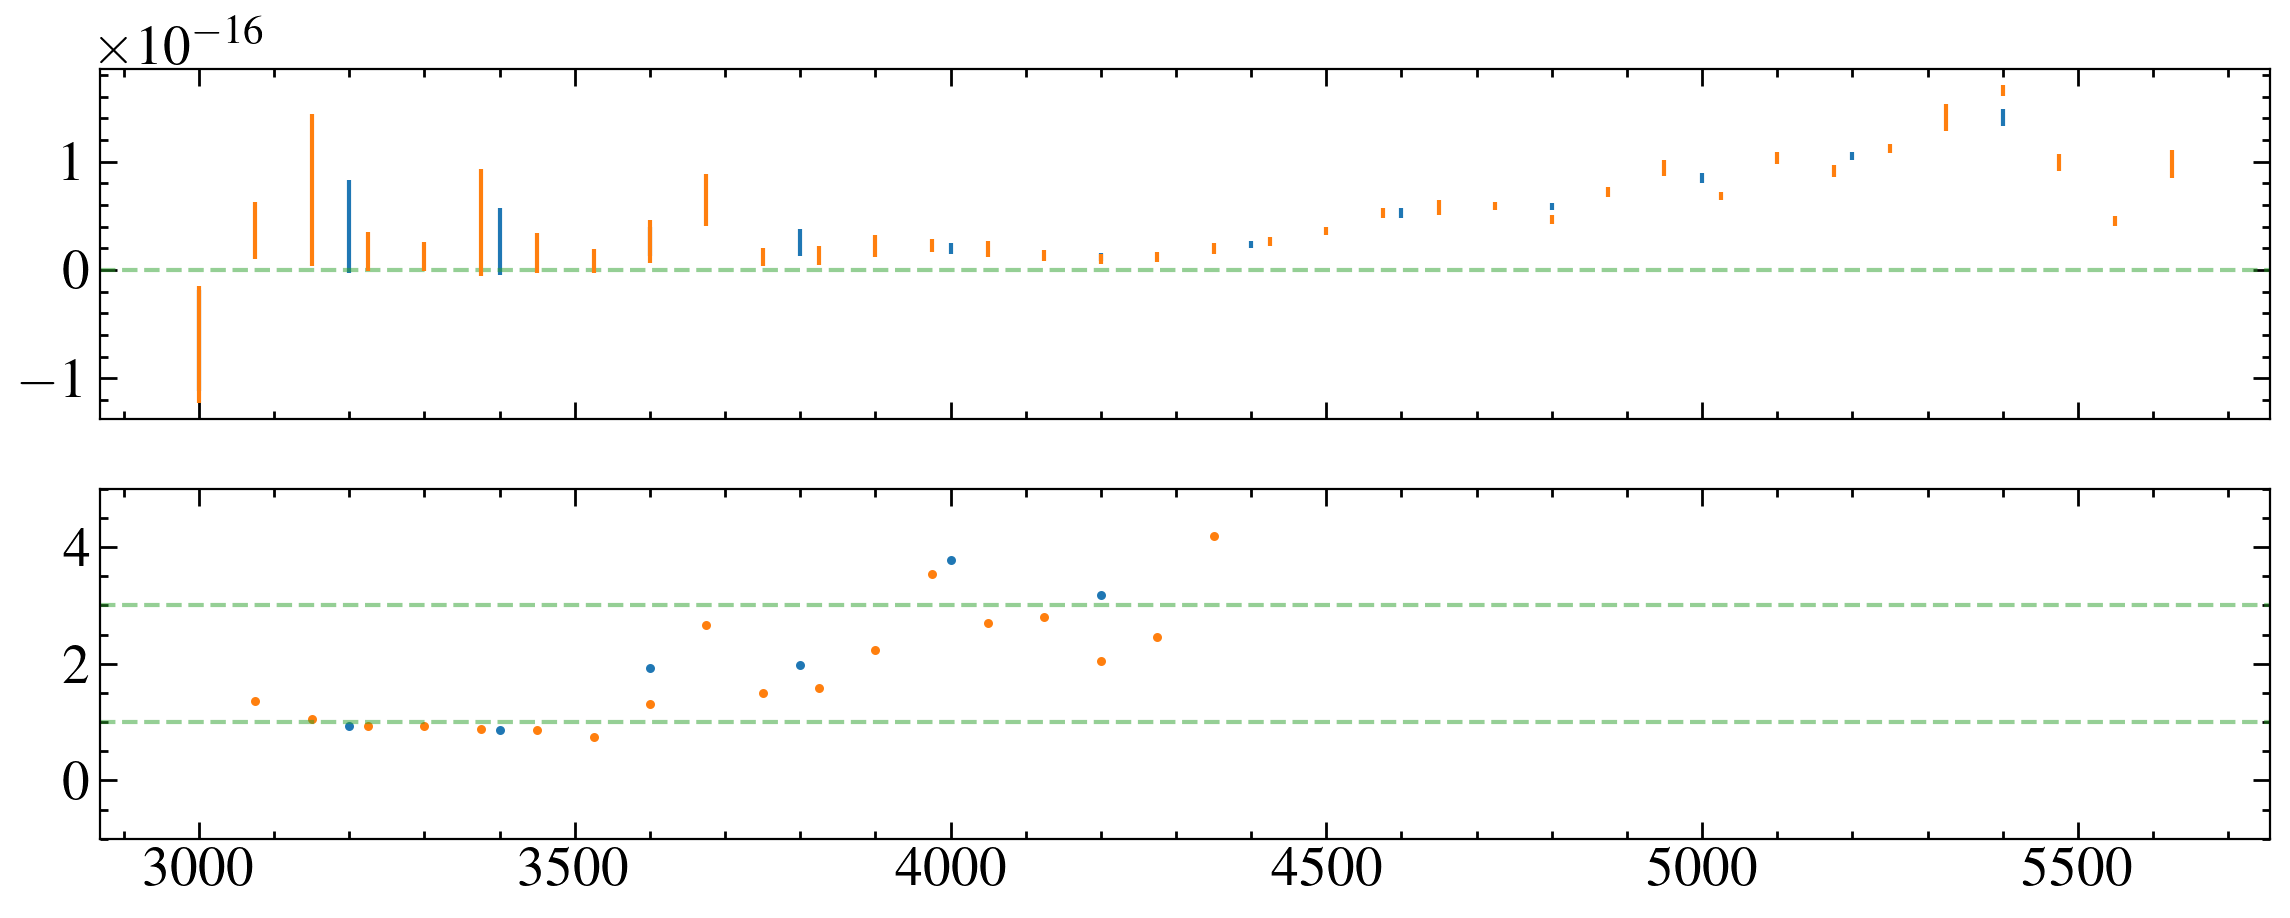

In [8]:
new_wavelength = np.arange(3000, 5690, 200)
print(len(new_wavelength))
fluxcon = FluxConservingResampler(extrapolation_treatment='zero_fill')
input_spec = Spectrum1D(spectral_axis=w1*u.AA, flux=f1*u.Unit('erg cm-2 s-1 AA-1') , uncertainty= StdDevUncertainty(e1))
new_spec_fluxcon = fluxcon(input_spec, new_wavelength*u.AA)
w2 = (new_spec_fluxcon.spectral_axis.value)
f2 = (new_spec_fluxcon.flux.value)
e2 = (1/(new_spec_fluxcon.uncertainty.array**0.5))


fig, ax = plt.subplots(nrows=2, sharex=True)
# ax.step(w2, f2, where='mid')
# ax.step(w2, e2, alpha=0.5, where='mid')
ax[0].errorbar(w2, f2, yerr=e2, ls='none', c='C0')

ax[0].axhline(0, ls='--', c='C2', alpha=0.5)

ax[1].scatter(w2, f2/e2, s=5, c='C0')

ax[1].set_ylim(-1, 5)
ax[1].axhline(3, ls='--', c='C2', alpha=0.5)
ax[1].axhline(1, ls='--', c='C2', alpha=0.5)



new_wavelength = np.arange(3000, 5690, 75)
print(len(new_wavelength))
fluxcon = FluxConservingResampler(extrapolation_treatment='zero_fill')
input_spec = Spectrum1D(spectral_axis=w1*u.AA, flux=f1*u.Unit('erg cm-2 s-1 AA-1') , uncertainty= StdDevUncertainty(e1))
new_spec_fluxcon = fluxcon(input_spec, new_wavelength*u.AA)
w2 = (new_spec_fluxcon.spectral_axis.value)
f2 = (new_spec_fluxcon.flux.value)
e2 = (1/(new_spec_fluxcon.uncertainty.array**0.5))


ax[0].errorbar(w2, f2, yerr=e2, ls='none', c='C1')

ax[1].scatter(w2, f2/e2, s=5, c='C1')




3600 looks right. Where is the moving cut off? early apparently.


In [9]:
phxpath = '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/TRAPPIST-1/hlsp_muscles_model_phx_trappist-1_na_v24_component-spec.fits'

phx = fits.getdata(phxpath, 1)
phxnorm = fits.getheader(phxpath, 0)['NORMFAC']
pwi, pfi = phx['WAVELENGTH'], phx['FLUX']*phxnorm
pmask = (pwi > 3500) & (pwi < 5700)
pw, pf = pwi[pmask], pfi[pmask]
pf = convolve(pf, Gaussian1DKernel(200))


1.3357776182009008e-10 erg / (s cm2)
849188017.9632366 erg / (s cm2)


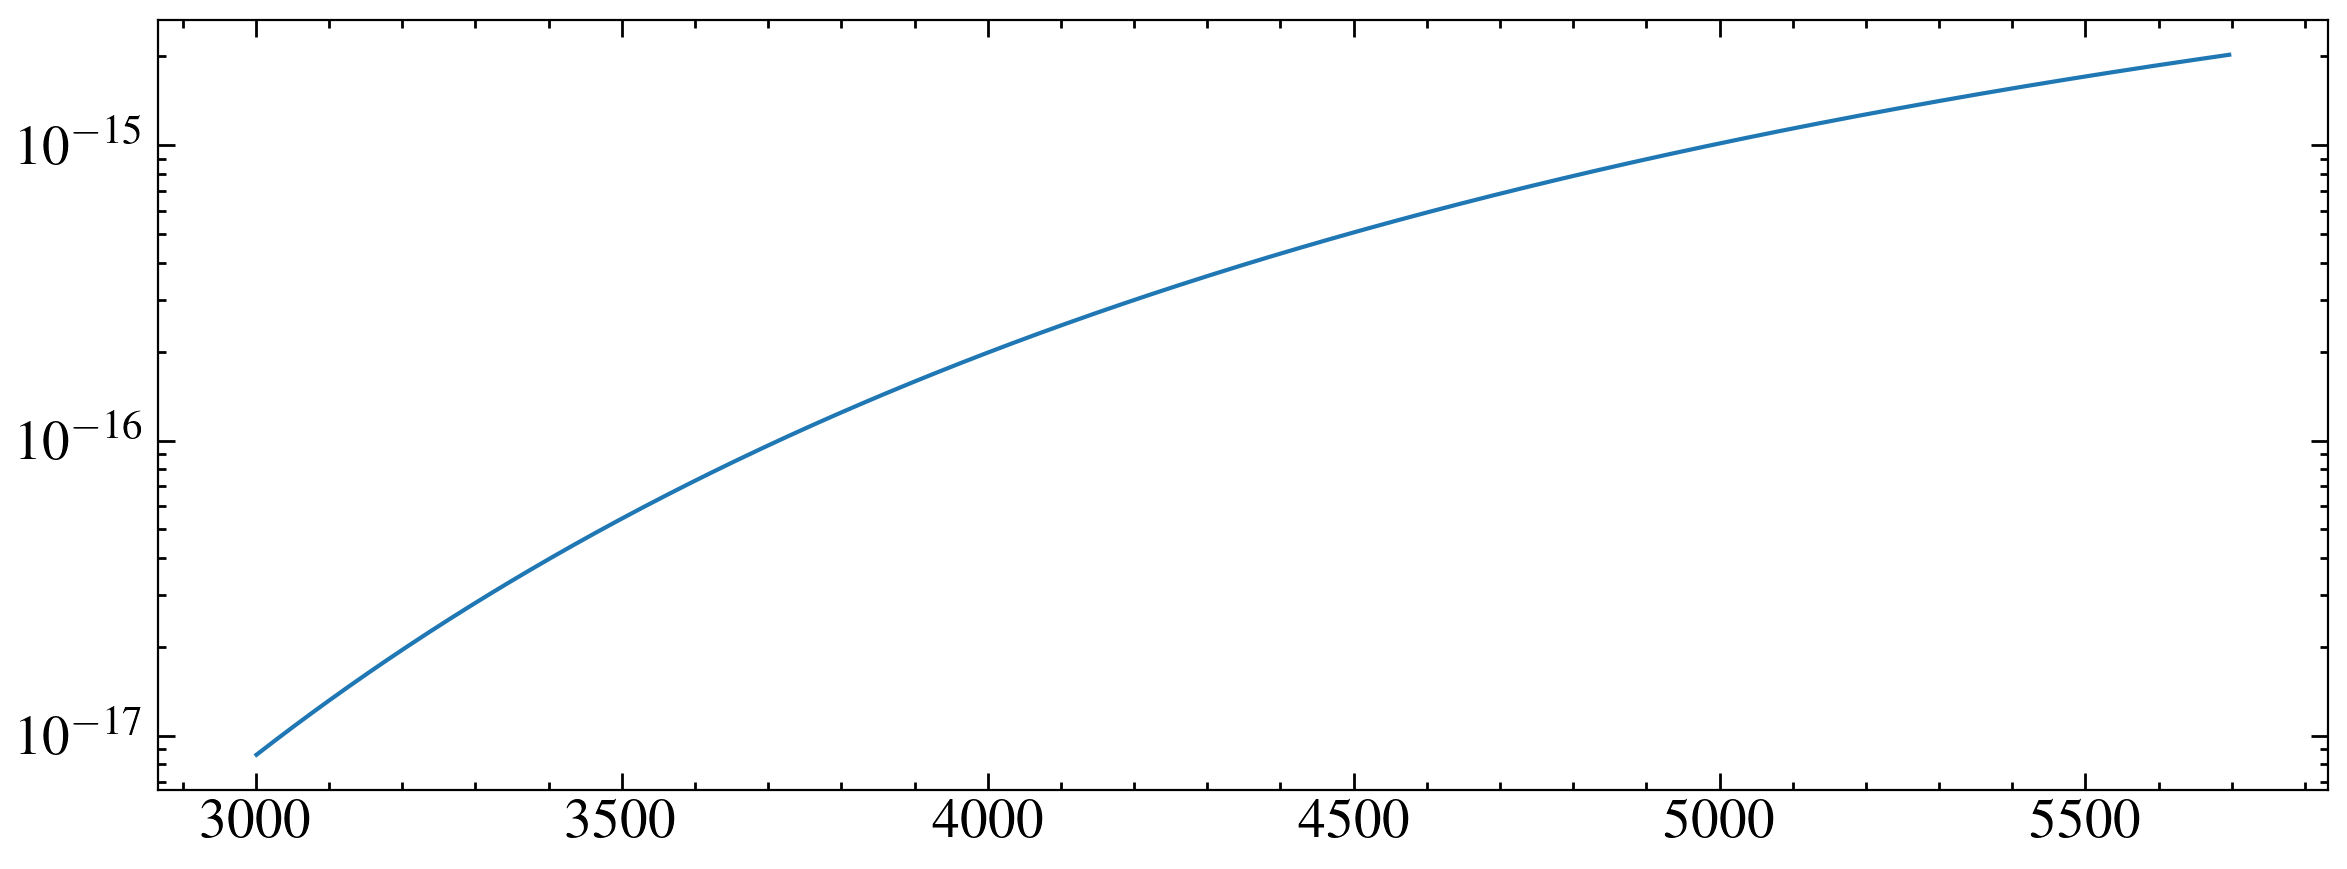

In [10]:
from astropy.modeling.models import BlackBody
#blackbody
lstar = 0.234e31*u.erg/u.s
tstar= 2619*u.K
rstar = 0.12*u.Rsun 
dstar = 12.1*u.pc
fstar = lstar/(4*np.pi*dstar.to(u.cm)**2)
print(fstar)
bb = BlackBody(temperature=tstar, scale=1*u.erg/u.s/u.cm**2/u.sr)
bbflux = bb.bolometric_flux
print(bbflux)
# A = 4*np.pi*(rstar.to(u.cm))**2
# scale = lstar/ (bbflux * A) 
scale = fstar/bbflux
# bb = BlackBody(temperature=tstar, scale=1/scale)

bbf = bb(w1*u.AA)*scale*u.sr / w1
# print(bbf[0])

plt.plot(w1, bbf)

plt.yscale('log')

27


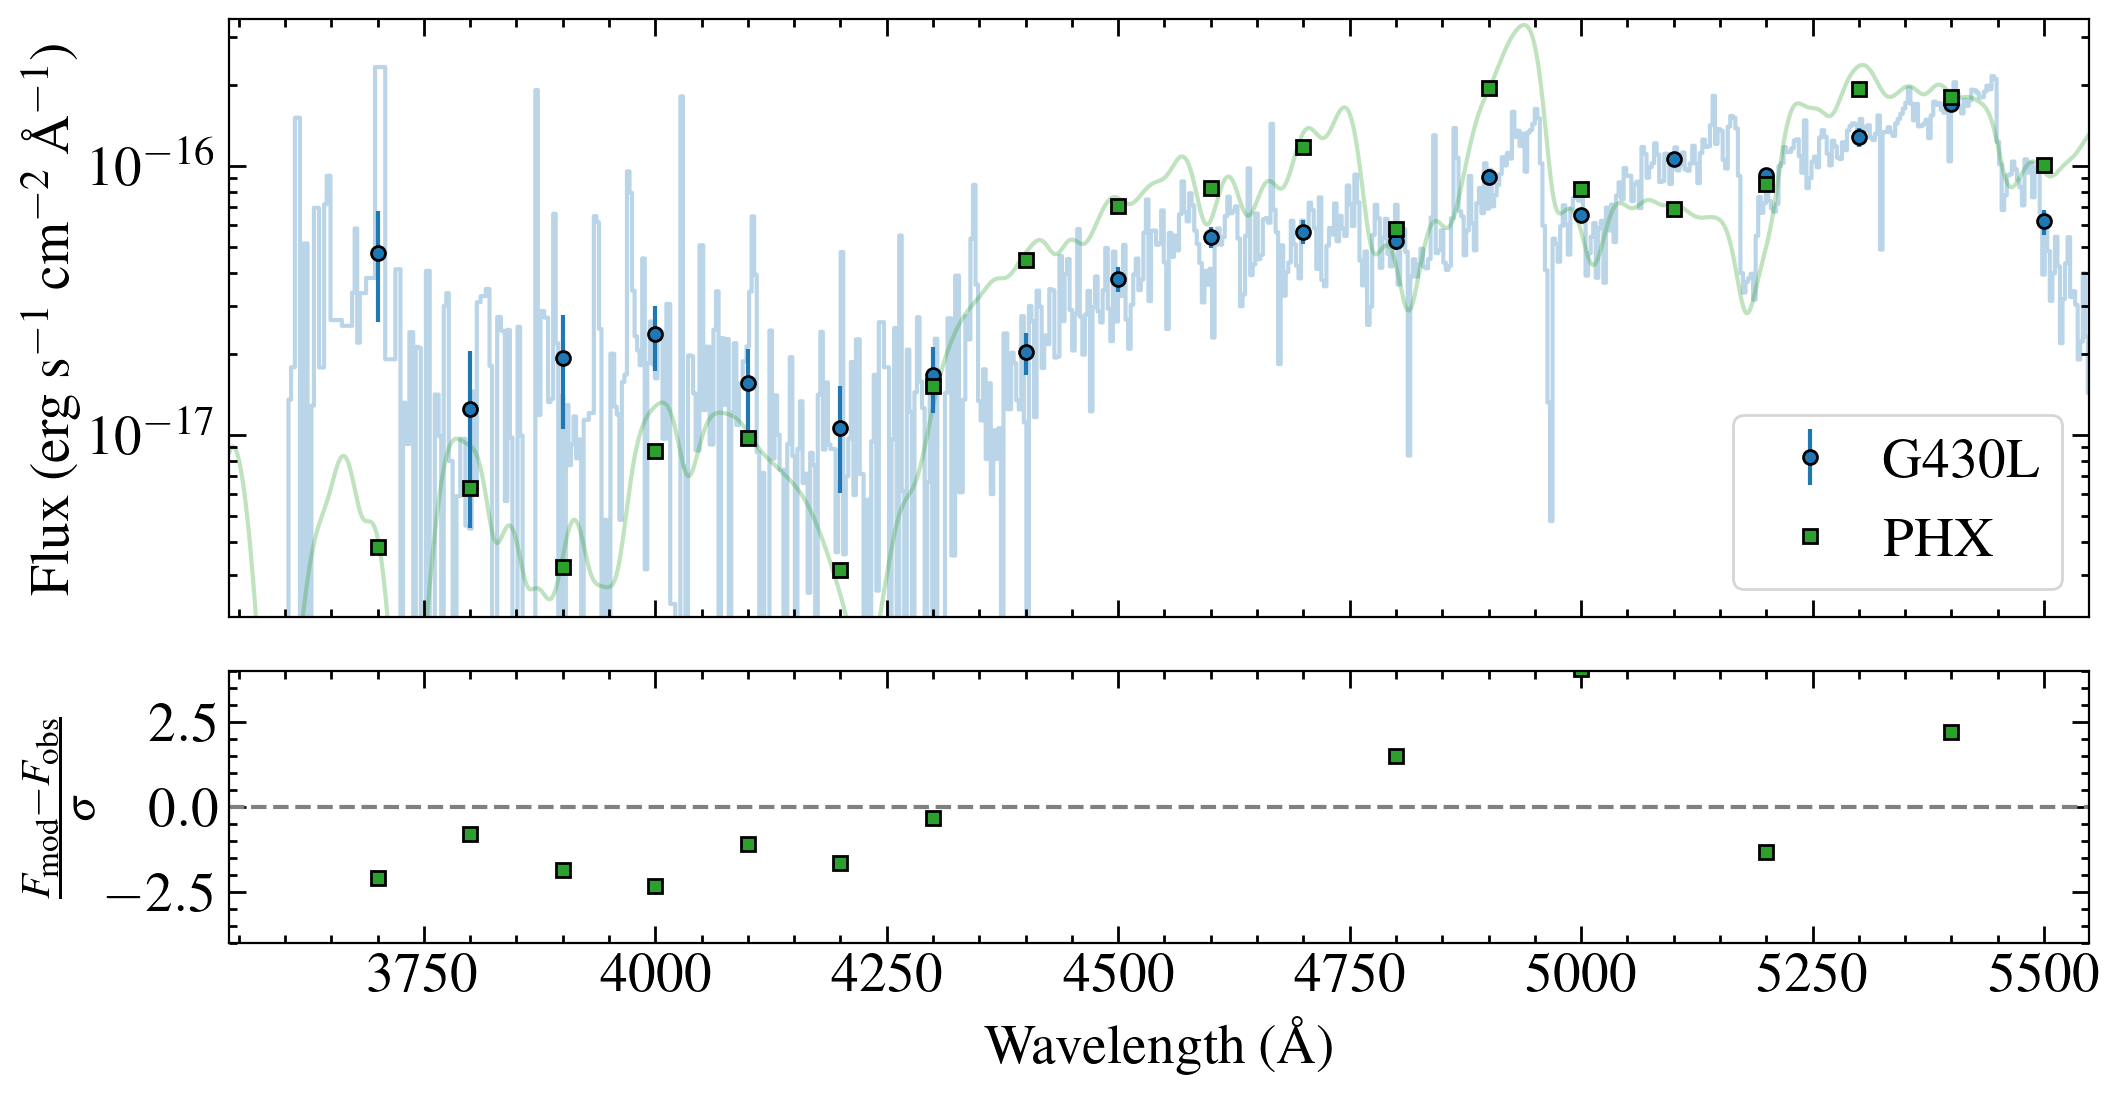

In [11]:
new_wavelength = np.arange(3000, 5690, 100)
print(len(new_wavelength))
fluxcon = FluxConservingResampler(extrapolation_treatment='zero_fill')
input_spec = Spectrum1D(spectral_axis=w1*u.AA, flux=f1*u.Unit('erg cm-2 s-1 AA-1') , uncertainty= StdDevUncertainty(e1))
new_spec_fluxcon = fluxcon(input_spec, new_wavelength*u.AA)
w2 = (new_spec_fluxcon.spectral_axis.value)
f2 = (new_spec_fluxcon.flux.value)
e2 = (1/(new_spec_fluxcon.uncertainty.array**0.5))


input_spec = Spectrum1D(spectral_axis=pw*u.AA, flux=pf*u.Unit('erg cm-2 s-1 AA-1'))
new_spec_fluxcon = fluxcon(input_spec, new_wavelength*u.AA)
pw2 = (new_spec_fluxcon.spectral_axis.value)
pf2 = (new_spec_fluxcon.flux.value)


# norm = max(f2)
# fig, ax = plt.subplots()
fig, axes = plt.subplot_mosaic([[0, 0, 0], [0, 0,0], [1, 1, 1]], sharex=True, figsize=(12, 6))
ax = axes[0]
mask = w2 > 3600
ax.errorbar(w2[mask], f2[mask], yerr=e2[mask], ls='none', c='C0', marker='o', markersize=5,  markeredgecolor='k', label='G430L')
mask = w1 > 3600
ax.step(w1[mask], f1[mask], where='mid', alpha=0.3, c='C0', zorder=-5)
# ax.step(w2[mask], e2[mask], alpha=0.5, where='mid')
mask = w2 > 3600
ax.errorbar(pw2[mask], pf2[mask] , ls='none', c='C2', marker='s', markersize=5, markeredgecolor='k', label='PHX')
ax.plot(pw, pf, alpha=0.3, c='C2', zorder=-4)

# ax.plot(w1, bbf)



ax.set_yscale('log')

ax.set_xlim(3540, 5549)
ax.set_ylim(2.1e-18, 3.5e-16)

ax.legend(frameon=True)

ratio =  pf2[mask]/f2[mask]
ratio_e = ratio*e2[mask]/f2[mask]
ratio_sig = (pf2[mask] - f2[mask])/e2[mask]

# axes[1].errorbar(w2[mask], ratio, yerr=ratio_e, ls='none', c='C3', marker='s', markersize=5, markeredgecolor='k')
axes[1].errorbar(w2[mask], ratio_sig, ls='none', c='C2', marker='s', markersize=5, markeredgecolor='k')

# axes[1].set_yscale('log')
axes[1].axhline(0, ls ='--', c='0.5')
axes[1].set_ylim(-4, 4)

axes[1].set_xlabel('Wavelength (\AA)')
axes[1].set_ylabel(r'$\frac{F_{\mathrm{mod}}-F_{\mathrm{obs}}} {\sigma}$')
ax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')

fig.savefig('plots/g430l_v_phx.pdf')

(1500, 1000000.0)

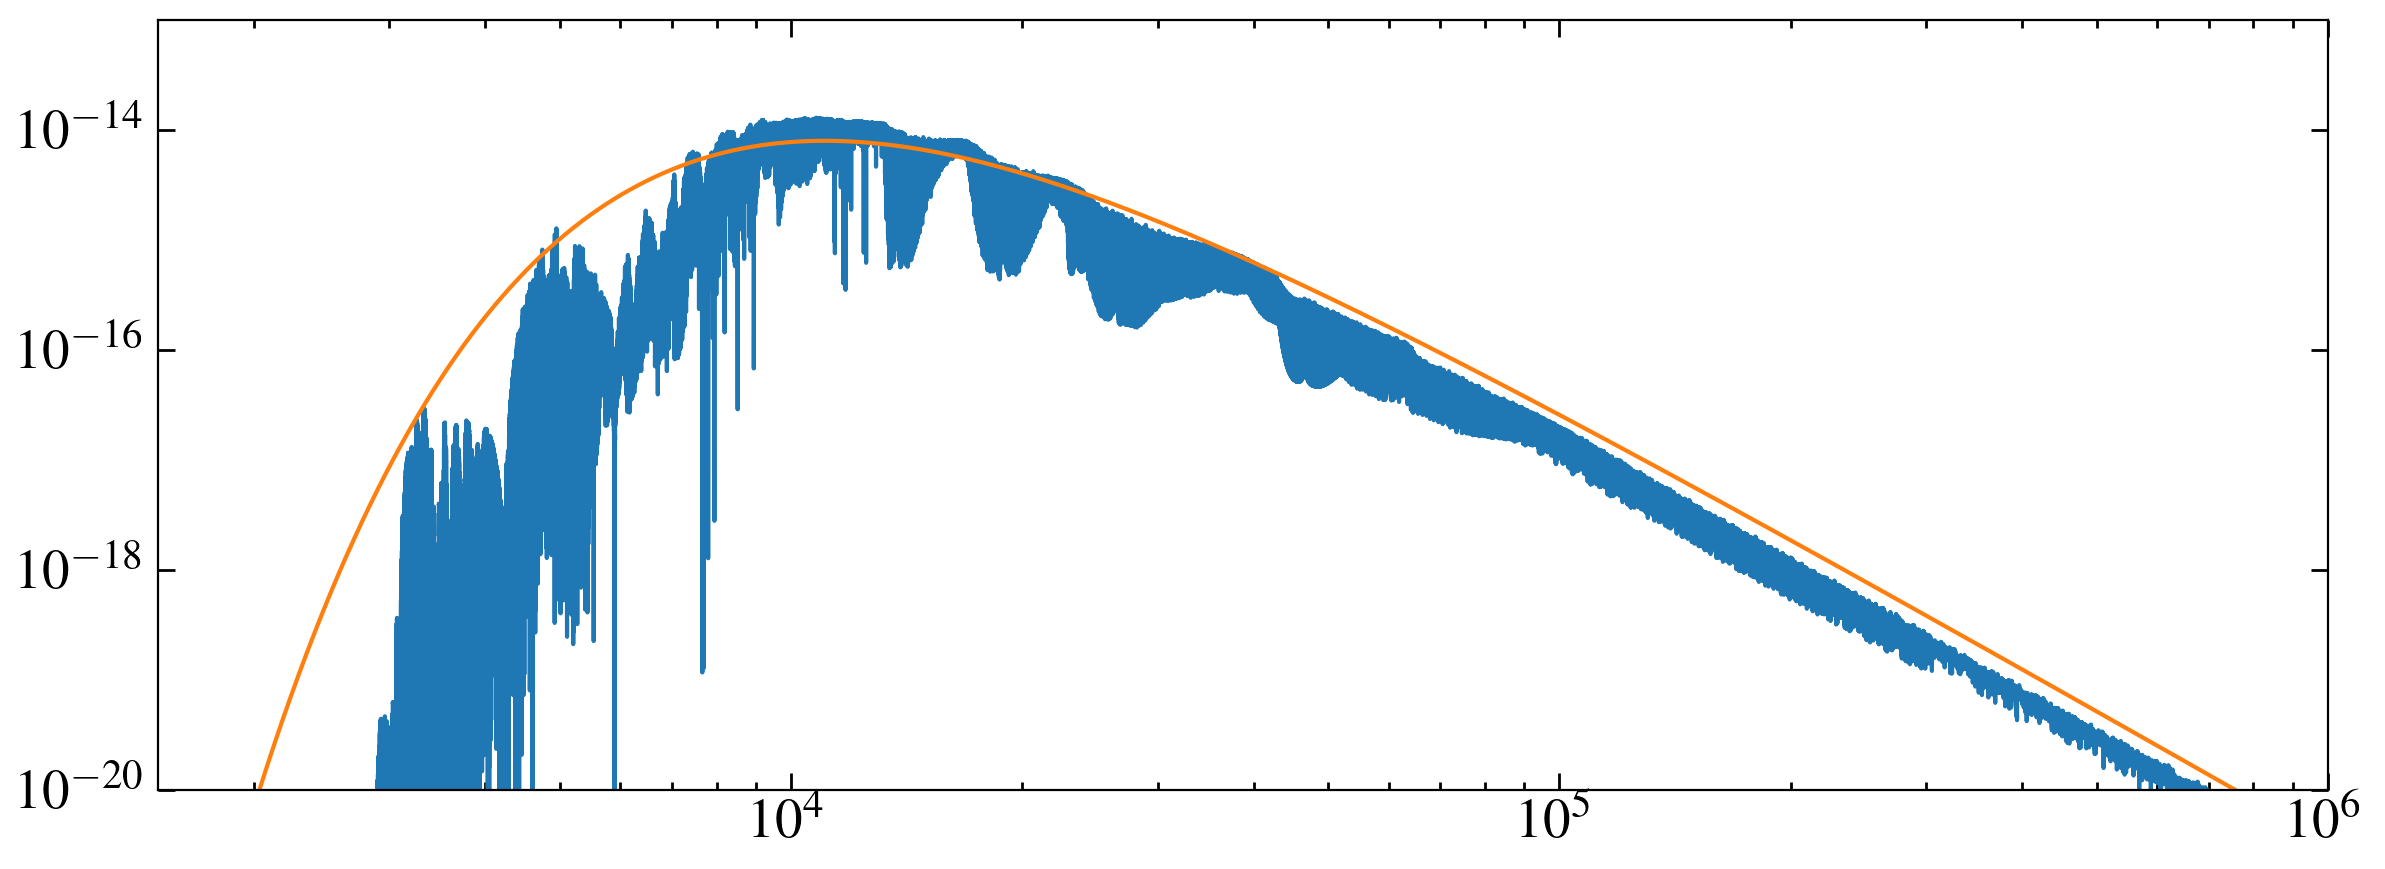

In [12]:
plt.plot(pwi, pfi)
plt.plot(pwi, bb(pwi*u.AA)*scale*u.sr / pwi)

plt.yscale('log')
plt.xscale('log')

plt.ylim(1e-20, 1e-13)
plt.xlim(1500, 1e6)

Need to replace the spectrum in the G430L HLSP file. This can be a problem for Next Week David. Next week is now, blast. Done.

In [13]:
# # ax.step(, data2['FLUX'], where='mid')

# print(data2['WAVELENGTH'][0], data2['WAVELENGTH'][-1])
# print(w[0], w[-1])

In [14]:
# print(len(w), len(data2['WAVELENGTH']))

In [15]:
# botch = Table.read('../optical/t1_g430m_edit.ecsv')
# len(botch['WAVELENGTH'])

In [16]:
def wavelength_edges(w):
    """
    Calulates w0 and w1
    """
    diff = np.diff(w)
    diff0 = np.concatenate((np.array([diff[0]]), diff)) #adds an extravalue to make len(diff) = len(w)
    diff1 = np.concatenate((diff, np.array([diff[-1]]))) #adds an extravalue to make len(diff) = len(w)
    w0 = w - diff0/2.
    w1 = w + diff1/2.
    return w0, w1

In [17]:
# print(data2[0])
# print(data2[45])

# data = fits.getdata('{}{}_sx1.fits'.format(path, root), 1)[0]
# w, f, e, dq = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ']

In [18]:
# olddatafits = hdul[1].data

# olddatafits.names

# exptime = olddatafits['EXPTIME'][50]
# expstart = olddatafits['EXPSTART'][50]
# expend = olddatafits['EXPEND'][50]

In [19]:
# w0, w1 = wavelength_edges(w)

# olddata = Table(hdul[1].data)

# olddata.keep_columns([])


# olddata['WAVELENGTH'] = w
# olddata['WAVELENGTH0'] = w0
# olddata['WAVELENGTH1'] = w1
# olddata['FLUX'] = f
# olddata['ERROR'] = w
# olddata['DQ'] = dq
# olddata['EXPTIME'] = np.full(len(w), exptime) #picking 50 to avoid edges
# olddata['EXPSTART'] = np.full(len(w), expstart)
# olddata['EXPEND'] = np.full(len(w), expend)





In [20]:

# hdr = fits.getheader('/media/david/2tb_ext_hd/hddata/mega_muscles/old_t1_g430l.fits', 1)
# hdul[1] = fits.BinTableHDU(olddata, header=hdr)

# # hdul[1].hdr = hdr
# hdul.writeto(hlsppath, overwrite=True)

# hdul = fits.open(hlsppath)
# olddatafits = hdul[1].data
# olddatafits['ERROR'] = e
# hdul.writeto(hlsppath, overwrite=True)



Clean version of the spectrum with regions in between emission lines coadded, emmison lines isolated

In [27]:
balwn = np.array([1.5233, 2.0565, 2.3032, 2.4373, 2.5181])/u.um
bv = balwn.to(u.AA, equivalencies=u.spectral())
print(bv[::-1])

[3971.2481633  4102.90075083 4341.78534213 4862.6306832  6564.69506991] Angstrom


[34, 80, 130]


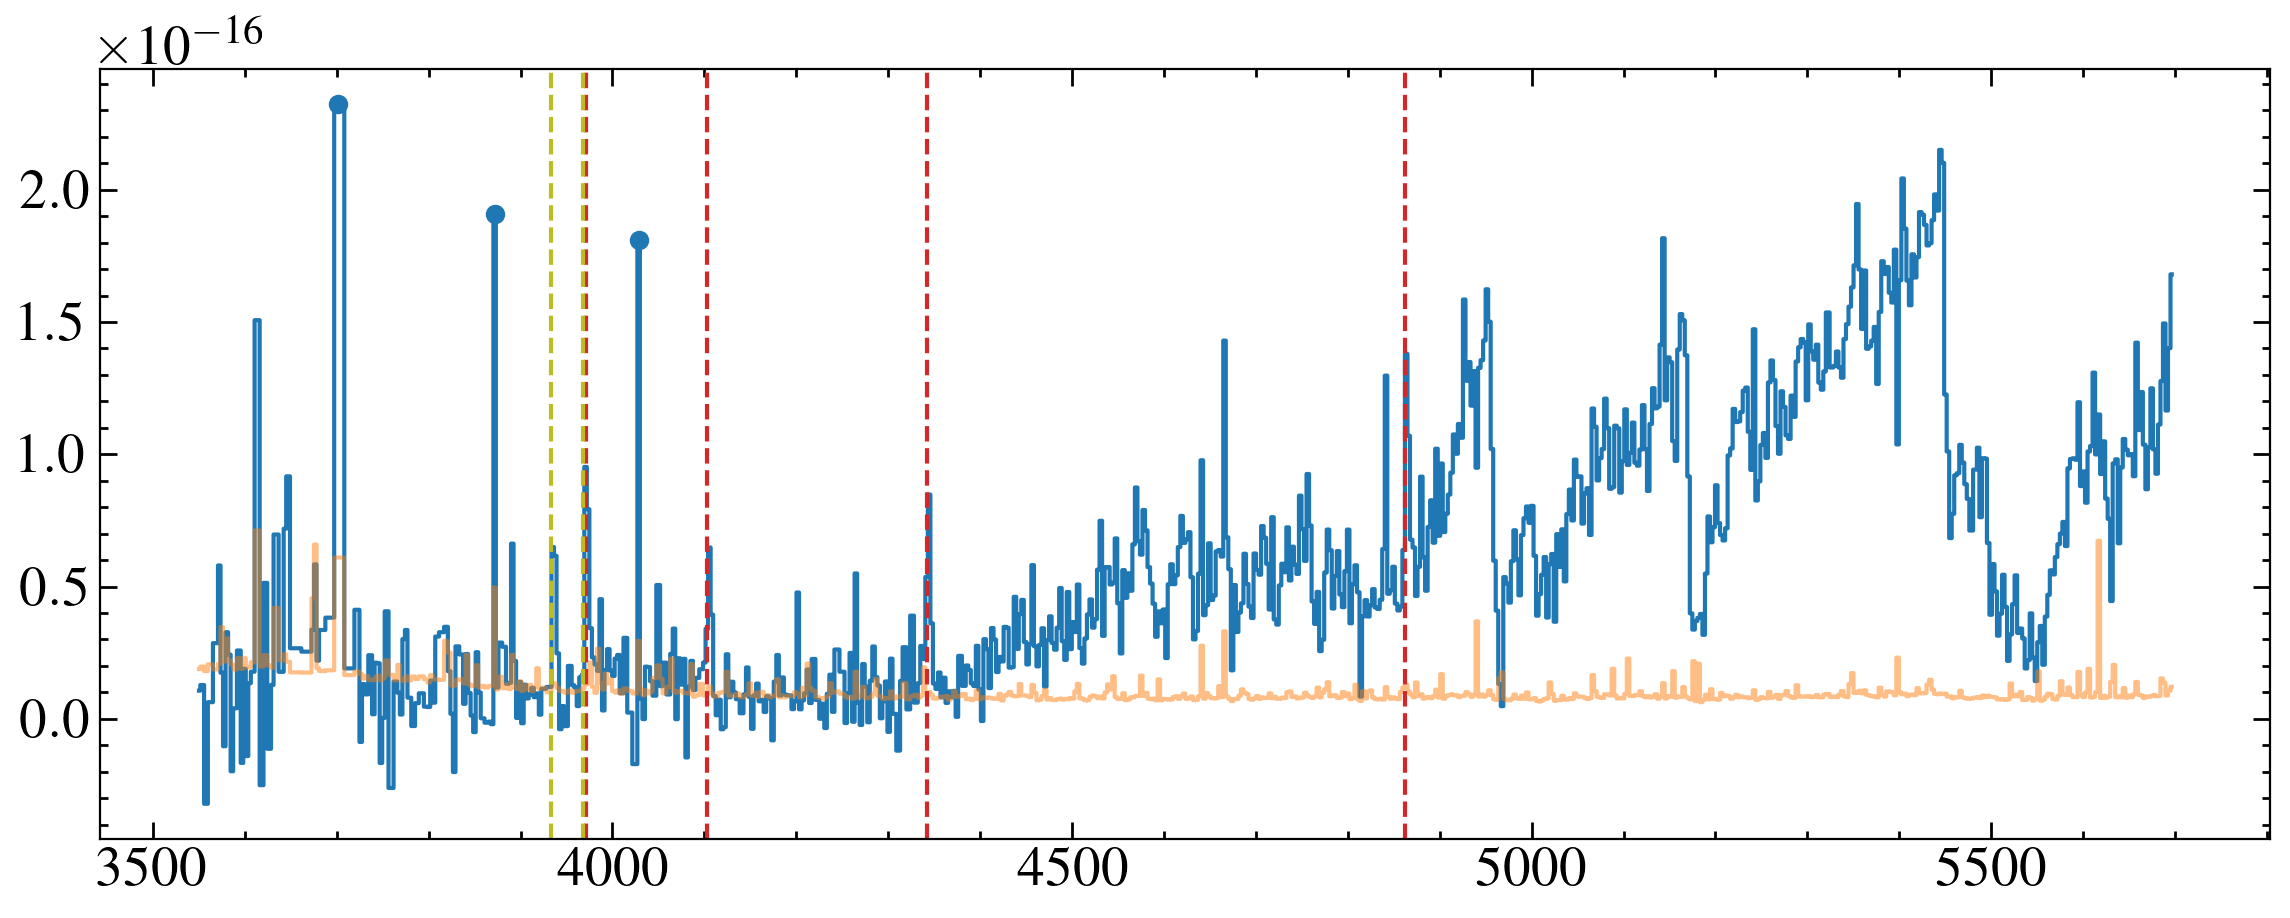

In [133]:
fig, ax = plt.subplots()
dq1 = dq - 16384  


mask = (w> 3550) & (dq1 <= 0) &  (f < 1e-15)
ax.step(w[mask], f[mask], where='mid')
ax.step(w[mask], e[mask], where='mid', alpha=0.5)

cahk =[ 3933.6614, 3968.4673]
bal = [3971.2481,  4102.9008, 4341.7853, 4862.6307,  6564.6950]
blended = [3968.4673, 3971.2481]

[ax.axvline(line, ls='--', c='C3') for line in bal[:-1]]
[ax.axvline(line, ls='--', c='C8') for line in cahk]


wsus = []
fsus = []
arg_sus = []
span = 50
for i in range(len(w[mask])-span):
    fi = f[mask][(i+int(span/2))]
    med = np.median(f[mask][i:i+span])
    std = np.std(f[mask][i:i+span])
    if fi > med + 5*std:# and f[mask][(i+1+int(span/2))] < med + 3*std:
        wsus.append(w[mask][i+int(span/2)])
        fsus.append(f[mask][i+int(span/2)])
        arg_sus.append(i+int(span/2))
ax.scatter(wsus, fsus)

print(arg_sus)
        
# ax.set_xlim(4800, 4900)

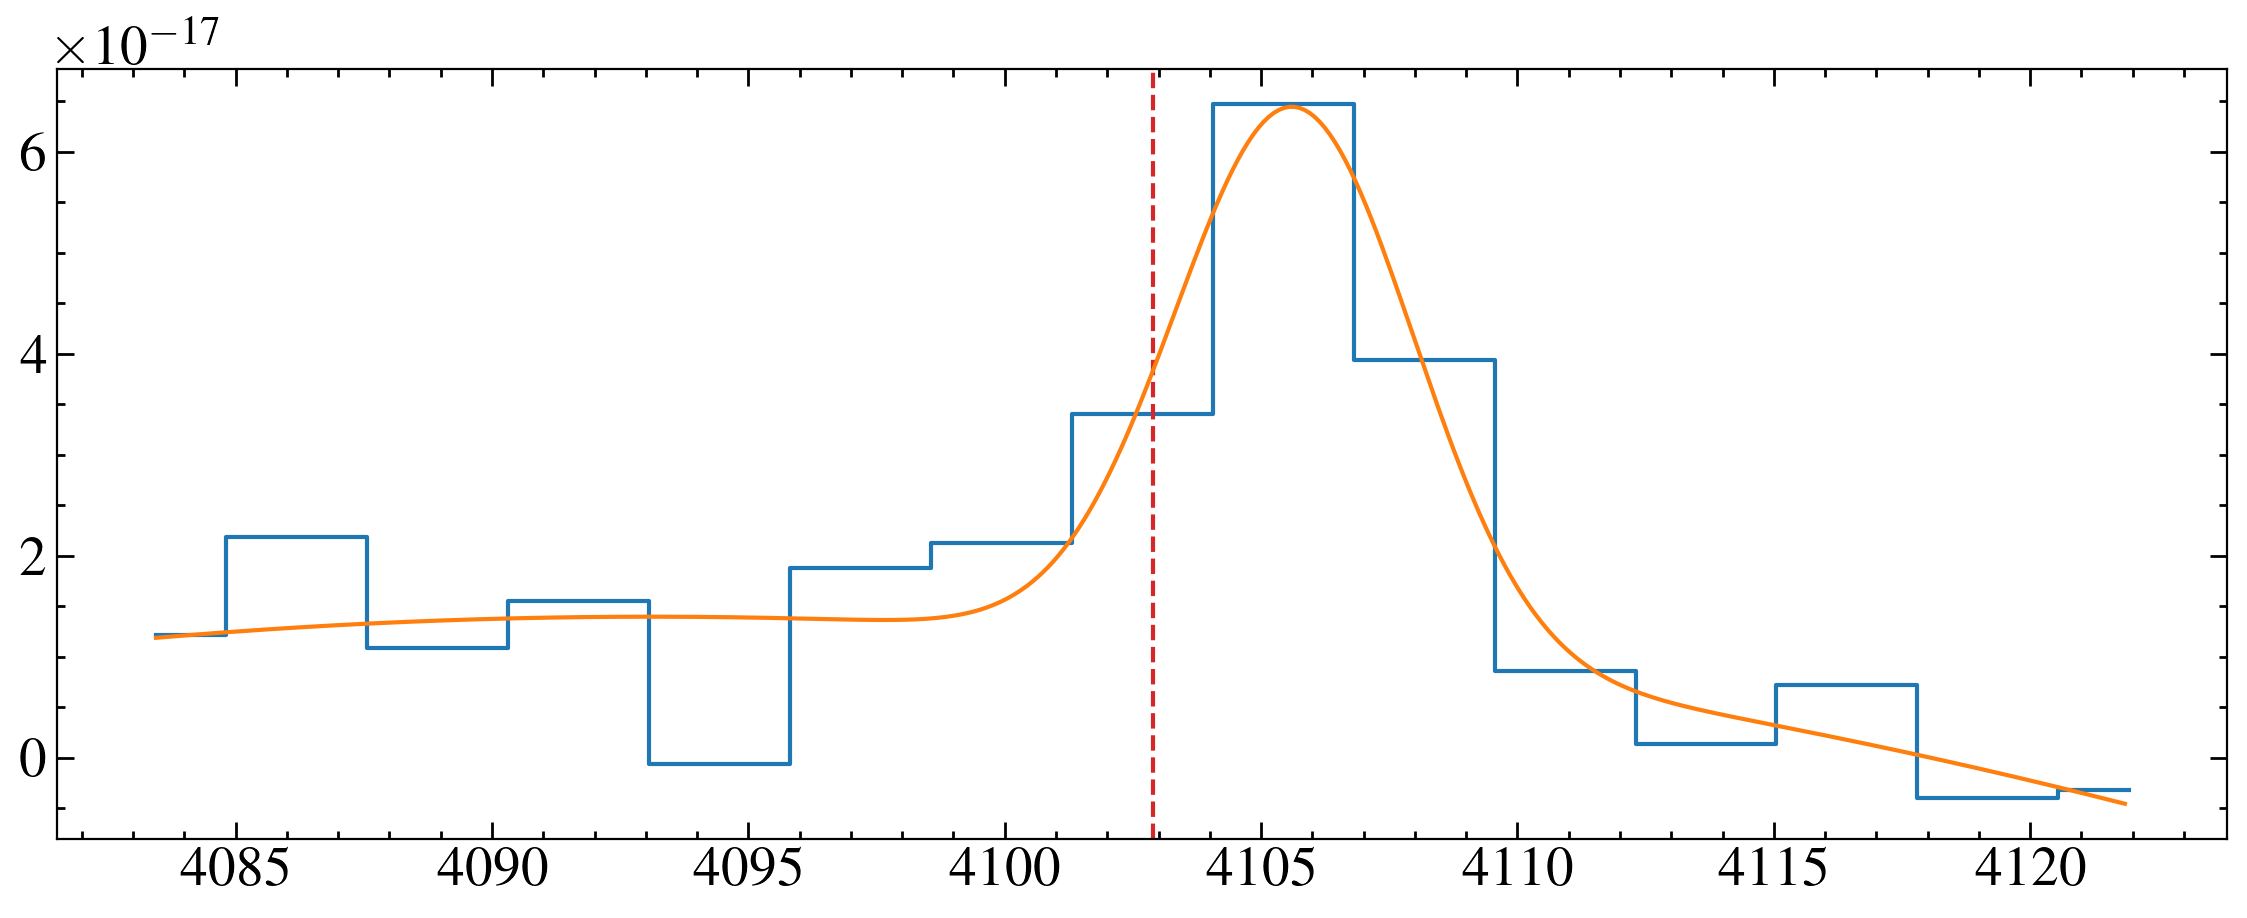

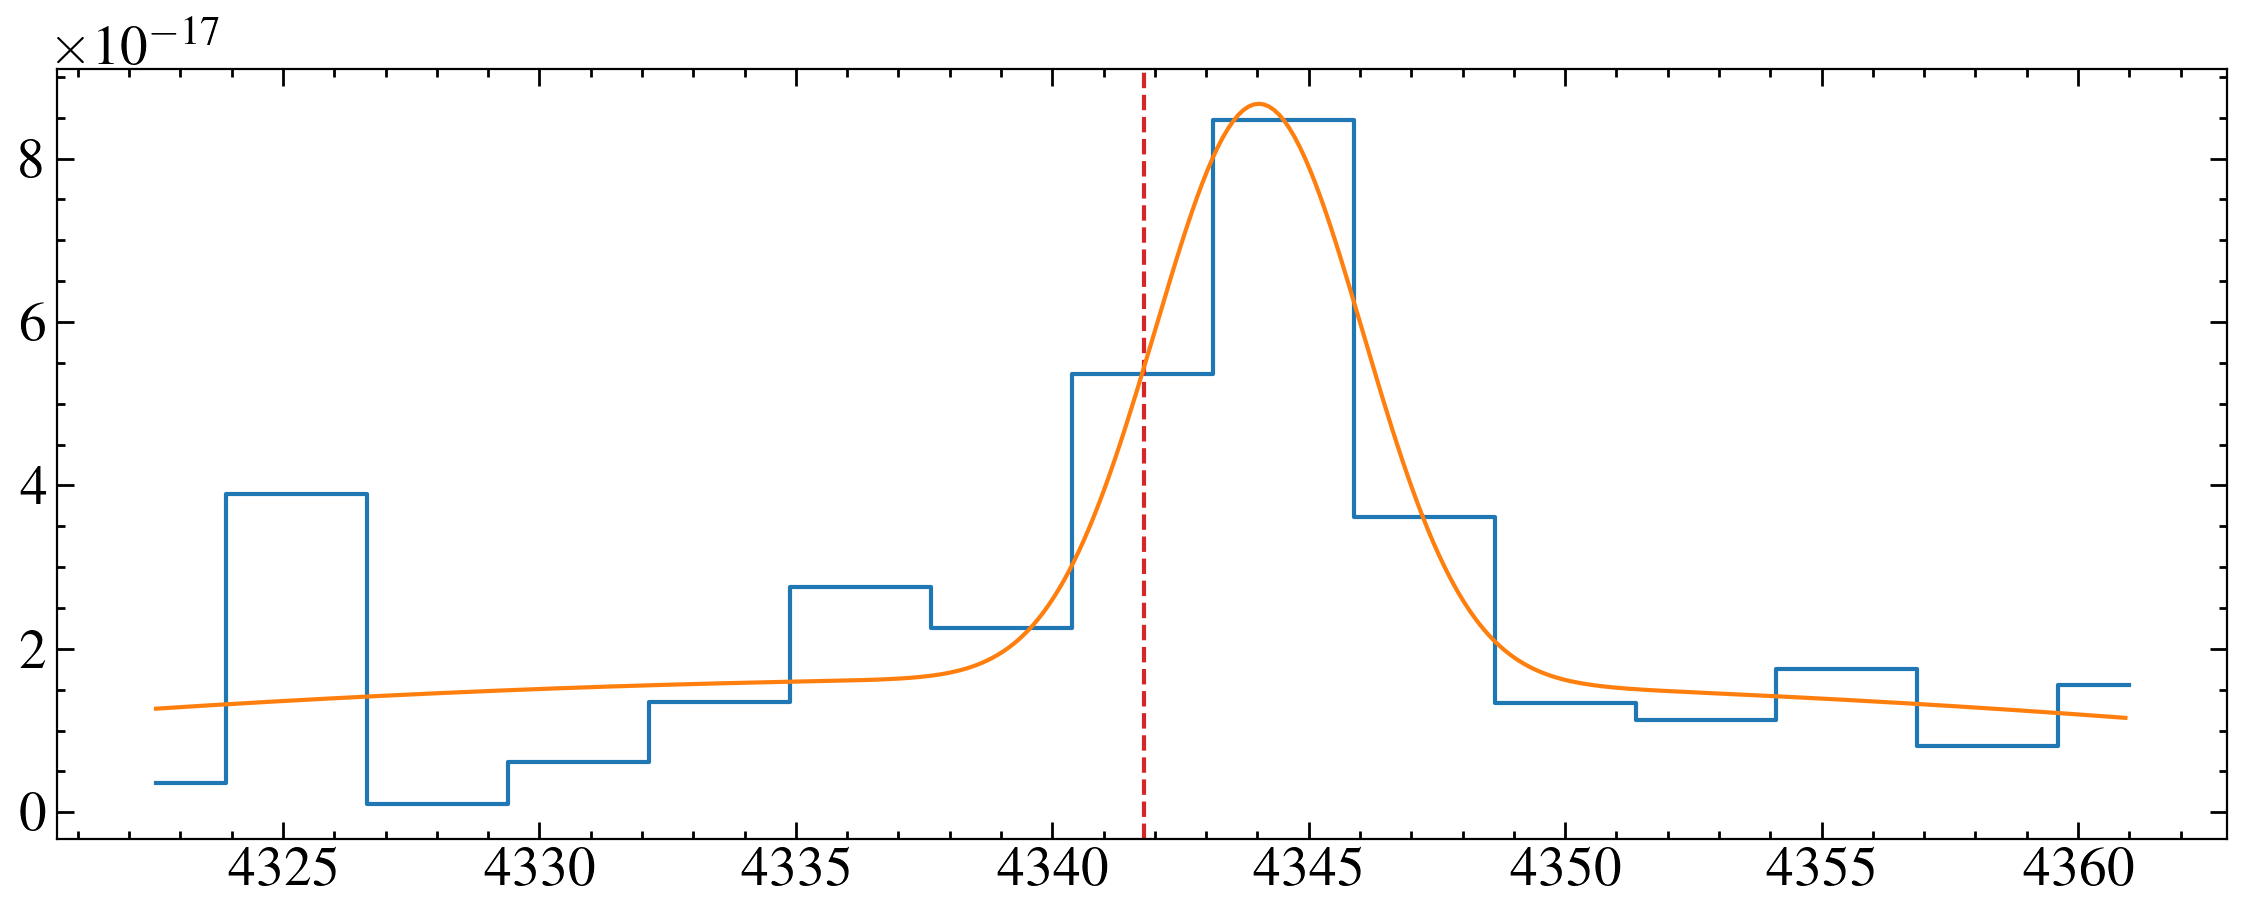

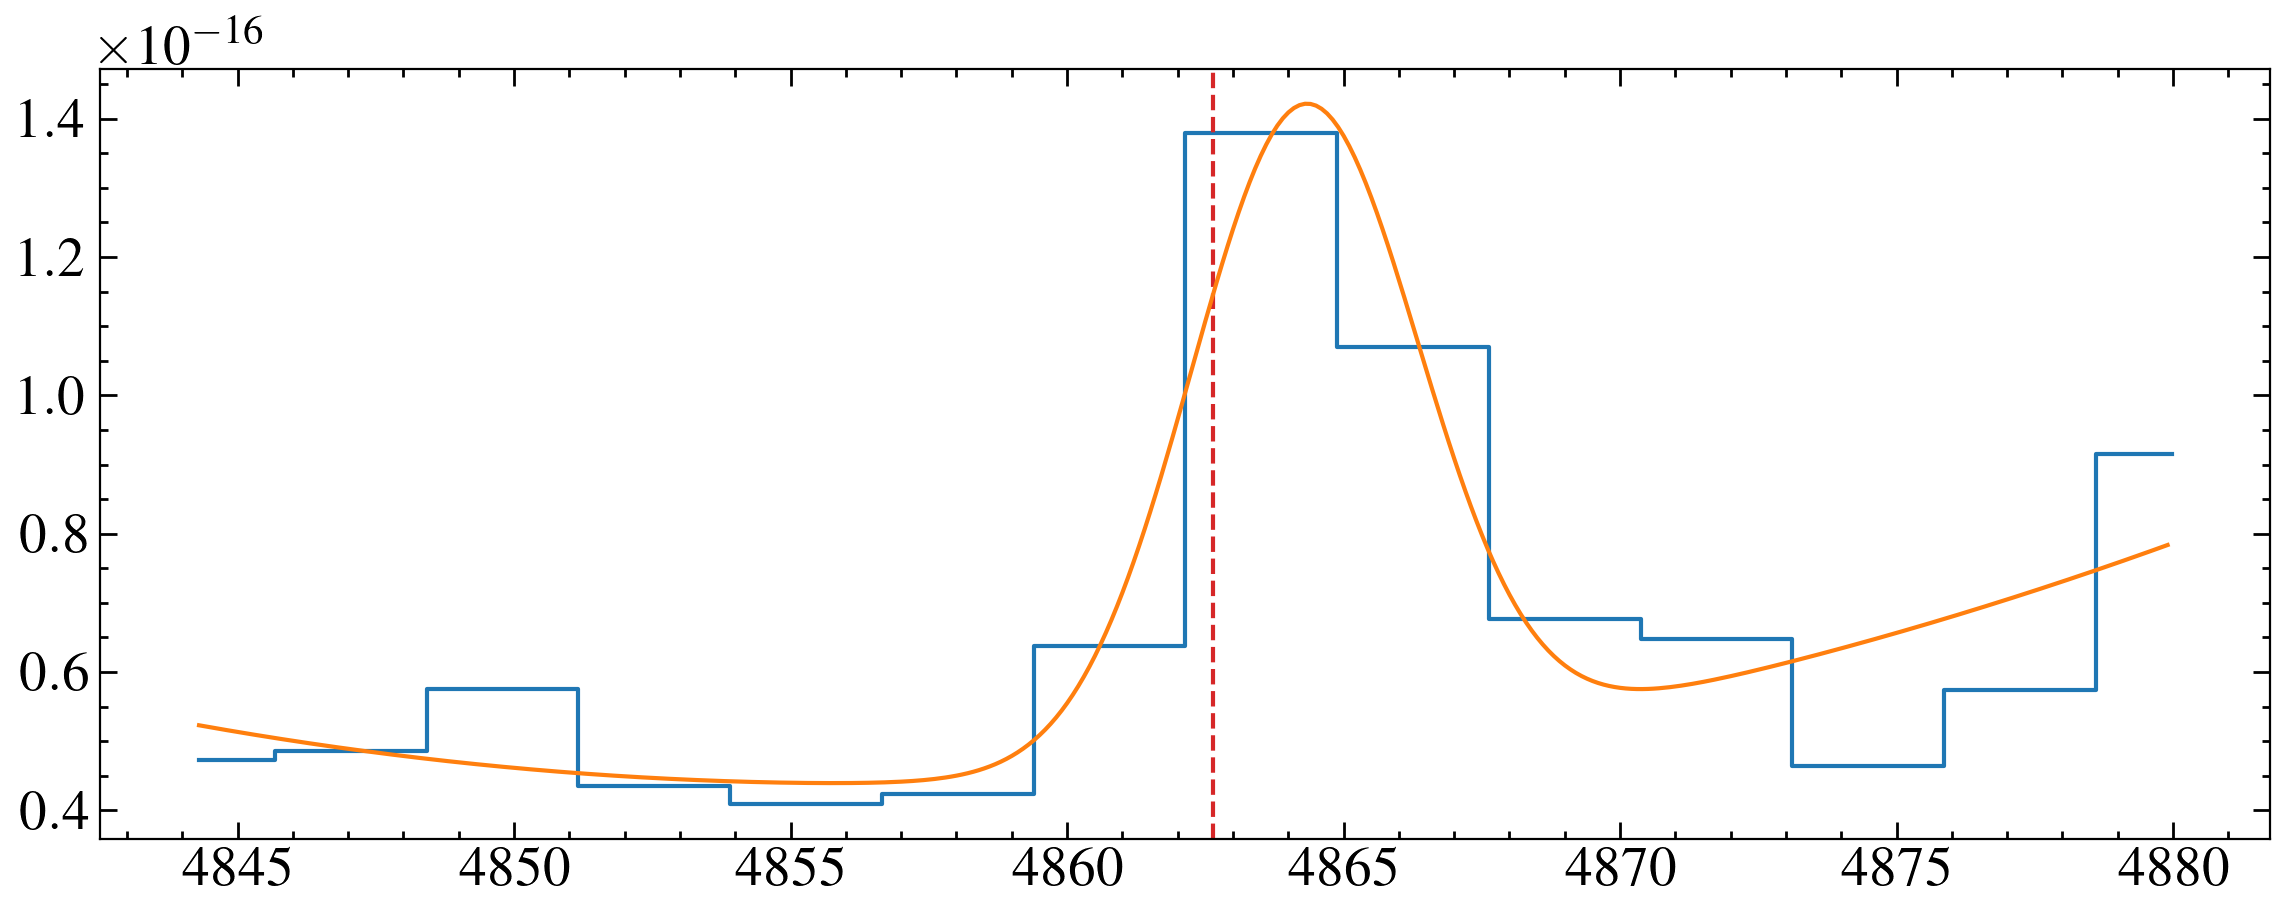

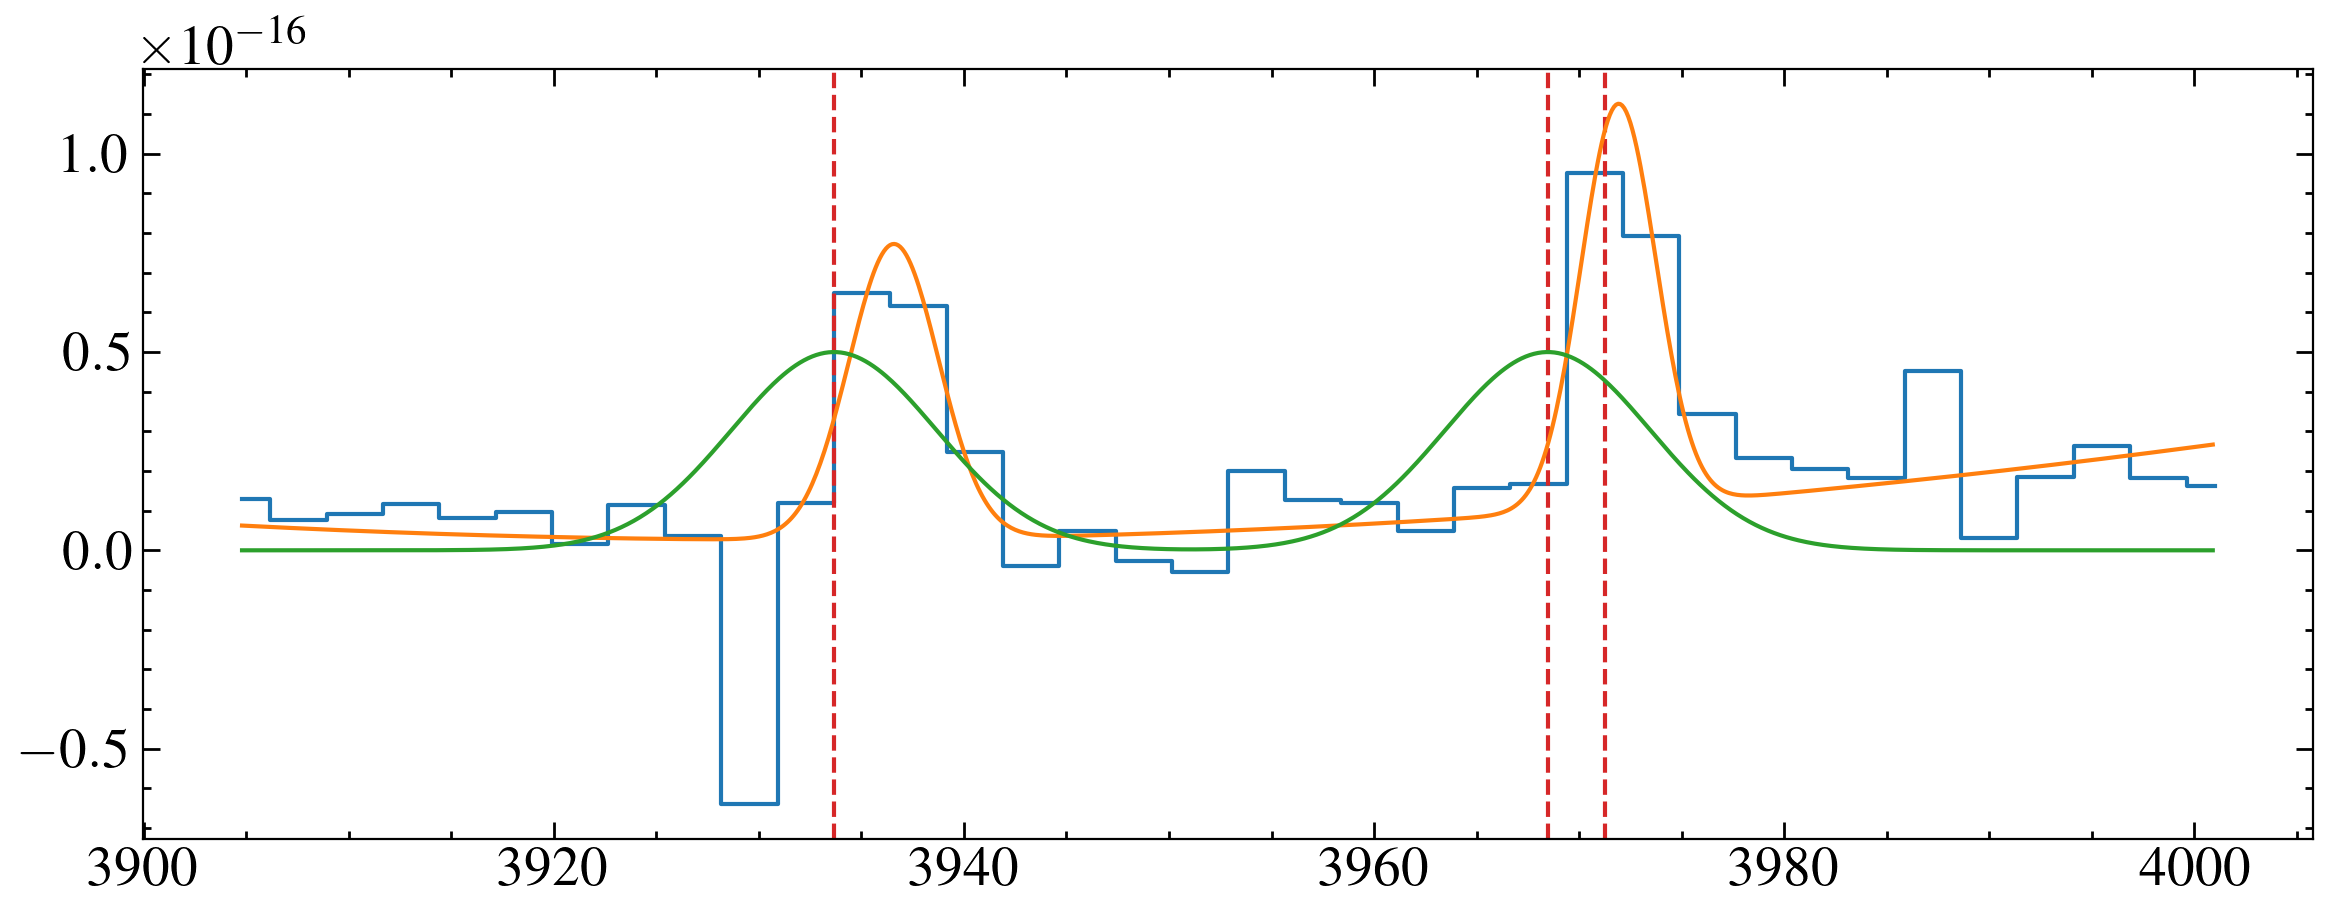

In [110]:
fitter = fitting.LevMarLSQFitter(calc_uncertainties=True)


for line in (bal[:-1]): #fit bals, then joint fit to close lines
    if line not in blended:
        fig, ax = plt.subplots()
        mask = (w > line -20) & (w < line +20)
        wfit, ffit , efit = w[mask], f[mask], e[mask]
        ax.step(wfit, ffit, where='mid')
        ax.axvline(line, ls='--', c='C3')
        # gg_init = models.Const1D(0.0)+models.Gaussian1D(1e-16, line, 10)
        gg_init = models.Polynomial1D(2)+models.Gaussian1D(1e-16, line, 5)
        gg_fit = fitter(gg_init, wfit, ffit, weights=1/efit, maxiter=10000)

        modw = np.arange(wfit[0], wfit[-1], 0.1)
        ax.plot(modw, gg_fit(modw))
        # ax.plot(modw, gg_init(modw))

        plt.show()

lines  =[ 3933.6614, 3968.4673,  3971.2481]


fig, ax = plt.subplots()
mask = (w > 3933.6614 -30) & (w < 3971.2481 +30)
wfit, ffit , efit = w[mask], f[mask], e[mask]
ax.step(wfit, ffit, where='mid')
[ax.axvline(line, ls='--', c='C3') for line in lines]
# gg_init = models.Const1D(0.0)#+models.Gaussian1D(1e-16, line, 10)
gg_init = models.Polynomial1D(2)
for line in lines[0:2]:
    gg_init=gg_init+models.Gaussian1D(0.5e-16, line, 5)
gg_fit = fitter(gg_init, wfit, ffit, weights=1/efit, maxiter=10000)

modw = np.arange(wfit[0], wfit[-1], 0.1)
ax.plot(modw, gg_fit(modw))
ax.plot(modw, gg_init(modw))


plt.show()

Can I just clean it up with the iterative aproach

In [117]:
def remove_negatives(w, f, e):
    """
    Iteratvly removes negative values by combining them with adjecent bins
    """
    wn, fn, en = w, f, e  
    nz = len(fn[fn <0.0]) 
    #     print(nz)
    minfi = np.argmin(fn) # most negative point
    fi = fn[minfi]
    while fi < 0:
        if len(fn) > 2: #can't handle an array less than 2 long
            w0, w1 = wavelength_edges(wn)
            delinds = [] #indices to delete when we're done
            start, end = minfi-1, minfi+2
            if minfi == 0: 
                start = minfi
            elif minfi == len(fn)-1:
                end = minfi +1
            delinds.append(start)
            delinds.append(end-1)
            fi = np.sum(fn[start:end]*(w1[start:end]-w0[start:end])) / (w1[end-1] - w0[start])
            ei = ((np.sum(en[start:end]**2 * (w1[start:end]-w0[start:end])**2))**0.5 ) / (w1[end-1] - w0[start])              
            wi = (w0[start]+w1[end-1])/2
            wn[minfi], fn[minfi], en[minfi] = wi, fi, ei
            delinds = np.array(delinds)
            delinds = np.unique(delinds[(delinds != minfi) & (delinds >= 0) & (delinds < len(fn)-1)])
            wn, fn, en  = np.delete(wn, delinds), np.delete(fn, delinds), np.delete(en, delinds)
            minfi = np.argmin(fn) # most negative point
            fi = fn[minfi]
            nz = len(fn[fn <0.0])
    #             print('len', len(fn))
    #             print(nz)
        else:
            fi = 1e9
    return(wn[fn >0], fn[fn >0], en[fn >0])


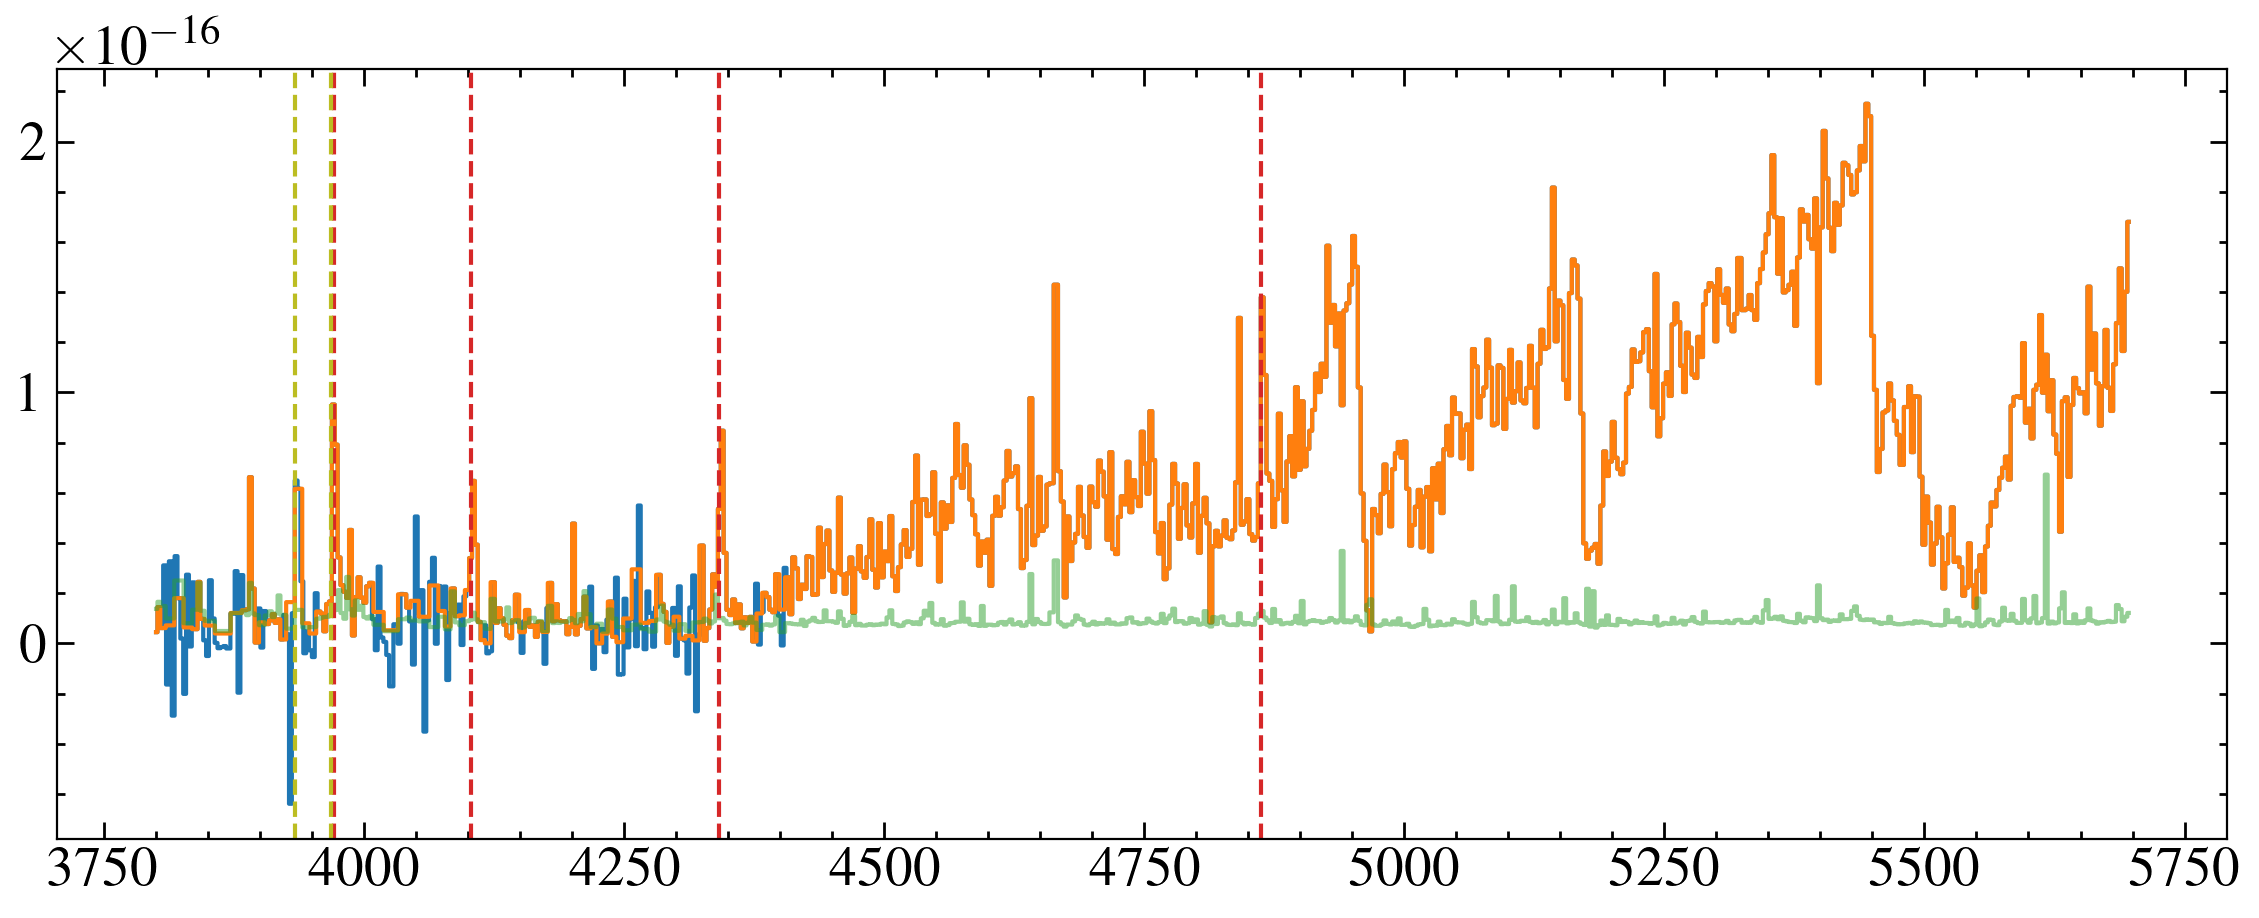

In [143]:
cos_args = [264, 296, 358, 415, 646,887, 944]


w1, f1, e1 = np.delete(w, cos_args), np.delete(f, cos_args), np.delete(e, cos_args)

fig, ax = plt.subplots()
dq1 = dq - 16384  
mask = (w1> 3800) 
ax.step(w1[mask], f1[mask], where='mid')

wn, fn, en = remove_negatives(w1[mask], f1[mask], e1[mask])

ax.step(wn, fn, where='mid')
ax.step(wn, en, where='mid', alpha=0.5)

cahk =[ 3933.6614, 3968.4673]
bal = [3971.2481,  4102.9008, 4341.7853, 4862.6307,  6564.6950]
blended = [3968.4673, 3971.2481]

[ax.axvline(line, ls='--', c='C3') for line in bal[:-1]]
[ax.axvline(line, ls='--', c='C8') for line in cahk]



# ax.set_xlim(3800, 4600)
        
# ax.set_xlim(4800, 4900)

In [144]:
savdat = Table([wn *u.AA, fn*u.erg/u.s/u.cm**2/u.AA, en*u.erg/u.s/u.cm**2/u.AA], names =['WAVELENGTH', 'FLUX', 'ERROR'])
savdat.write('g140m_for_sed.ecsv', overwrite=True)